### https://github.com/ksopyla/svm_mnist_digit_classification/tree/master
### https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [9]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', return_X_y=True)

In [12]:
# ensures randomized order of the dataset
random_state = check_random_state(0)

# random shuffling X and y
# X is a pandas DataFrame, so we need to convert to numpy array first
X_array = X.to_numpy()
y_array = y.to_numpy()
permutation = random_state.permutation(X_array.shape[0])
X_array = X_array[permutation]
y_array = y_array[permutation]
X = X_array
y = y_array

# Converts input features into a 2D format for logistic regression or SVMs
X = X.reshape((X.shape[0], -1))

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

### EDA

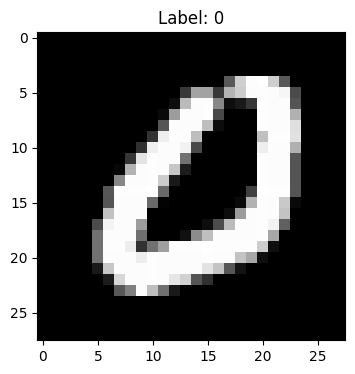

In [36]:
import matplotlib.pyplot as plt

# have a look at the image
image_index = 21  
image = X[image_index].reshape(28, 28)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")
plt.title(f"Label: {y[image_index]}")  # Display corresponding label
plt.show()


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1)  # 10% of the training data for validation

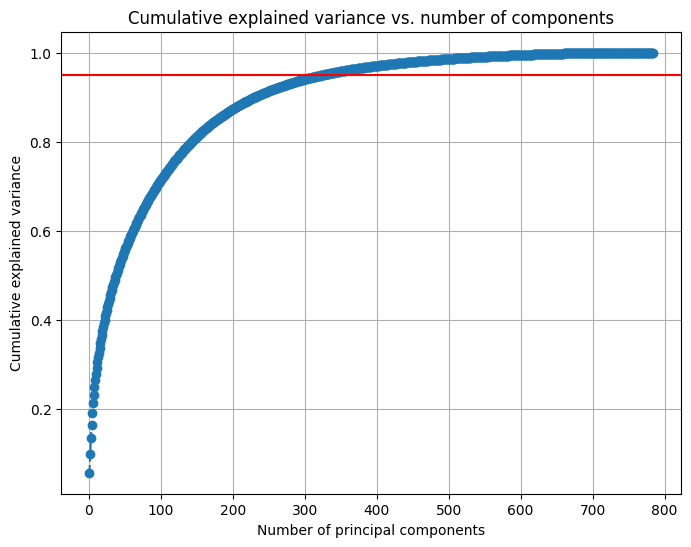

325


In [14]:
from sklearn.decomposition import PCA

# Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Compute the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance to determine the number of components for 95% threshold
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs. number of components")
plt.grid()
plt.show()

# Determine the number of components needed for 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=num_components_95)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(num_components_95)

In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_pca)
X_val_std = scaler.transform(X_val_pca)
X_test_std = scaler.transform(X_test_pca)

In [16]:

# Create a classifier
clf = svm.SVC(gamma=0.0001)
clf.fit(X_train_std, y_train)

# Calculate and output validation accuracy
val_acc = clf.score(X_val_std, y_val)
print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.9102


In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [1, 5, 10],   # Regularization parameter
    'gamma': [0.0001, 0.001, 0.01],  # Kernel coefficient for RBF
    }

# Create an SVM classifier
clf = svm.SVC()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_std, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

# Calculate and print the validation accuracy of the best model
val_accuracy = best_model.score(X_val_std, y_val)
print(f"Best parameters: {best_params}, Cross-validation score: {best_score:.4f}, Validation accuracy: {val_accuracy:.4f}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...................................C=1, gamma=0.001; total time= 5.0min
[CV] END ...................................C=1, gamma=0.001; total time= 5.0min
[CV] END ...................................C=1, gamma=0.001; total time= 5.0min
[CV] END ....................................C=1, gamma=0.01; total time= 9.8min
[CV] END ....................................C=1, gamma=0.01; total time=10.2min
[CV] END ..................................C=1, gamma=0.0001; total time=10.4min
[CV] END ..................................C=5, gamma=0.0001; total time= 5.4min
[CV] END ..................................C=5, gamma=0.0001; total time= 5.5min
[CV] END ..................................C=1, gamma=0.0001; total time=10.6min
[CV] END ..................................C=1, gamma=0.0001; total time=10.7min
[CV] END ...................................C=5, gamma=0.001; total time= 2.9min
[CV] END ...................................C=5, 

In [18]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test_std)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       955
           1       0.97      0.98      0.98      1089
           2       0.92      0.96      0.94      1011
           3       0.95      0.94      0.94      1021
           4       0.95      0.97      0.96       973
           5       0.96      0.94      0.95       904
           6       0.97      0.96      0.97       947
           7       0.96      0.94      0.95      1100
           8       0.97      0.95      0.96      1027
           9       0.97      0.95      0.96       973

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 800x600 with 0 Axes>

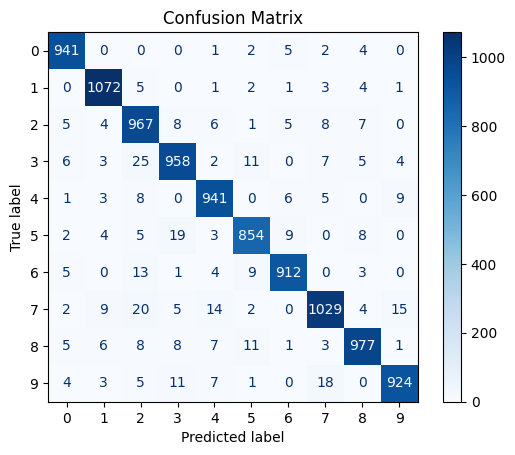

In [19]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test set
y_pred = best_model.predict(X_test_std)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
